In [66]:
import matplotlib.pyplot as plt

In [52]:
import os

base_dir = '../data'

train_dir = os.path.join(base_dir, 'train')
train_benign_dir = os.path.join(train_dir, 'benign')
train_malig_dir = os.path.join(train_dir, 'malignant')

test_dir = os.path.join(base_dir, 'test')
test_benign_dir = os.path.join(test_dir, 'benign')
test_malignant_dir = os.path.join(test_dir, 'malignant')

In [53]:
import tensorflow as tf

image_dim = 100  # change as needed

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(image_dim, image_dim, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [54]:
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(image_dim, image_dim))

test_datagen  = ImageDataGenerator(rescale = 1.0/255)
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(image_dim, image_dim))

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [58]:
history = model.fit(
            train_generator, # pass in the training generator
            steps_per_epoch=50,
            epochs=100,
            validation_data=test_generator, # pass in the validation generator
            validation_steps=20,
            verbose=1
            )

Epoch 1/100
50/50 [==============================] - 22s 443ms/step - loss: 0.3709 - accuracy: 0.8210 - val_loss: 0.3810 - val_accuracy: 0.8425
Epoch 2/100
50/50 [==============================] - 25s 490ms/step - loss: 0.3376 - accuracy: 0.8506 - val_loss: 0.3472 - val_accuracy: 0.8425
Epoch 3/100
50/50 [==============================] - 21s 414ms/step - loss: 0.3337 - accuracy: 0.8325 - val_loss: 0.3930 - val_accuracy: 0.8500
Epoch 4/100
50/50 [==============================] - 16s 318ms/step - loss: 0.3415 - accuracy: 0.8410 - val_loss: 0.3600 - val_accuracy: 0.8400
Epoch 5/100
50/50 [==============================] - 18s 367ms/step - loss: 0.2944 - accuracy: 0.8670 - val_loss: 0.3396 - val_accuracy: 0.8475
Epoch 6/100
50/50 [==============================] - 18s 363ms/step - loss: 0.2567 - accuracy: 0.8917 - val_loss: 0.3263 - val_accuracy: 0.8525
Epoch 7/100
50/50 [==============================] - 18s 361ms/step - loss: 0.3141 - accuracy: 0.8560 - val_loss: 0.3279 - val_accuracy:

1/1 [==============================] - 0s 127ms/step


/var/folders/px/1qj6sxcs61jb318jt36g_hdm0000gn/T/ipykernel_22708/3270454781.py:42: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
/var/folders/px/1qj6sxcs61jb318jt36g_hdm0000gn/T/ipykernel_22708/3270454781.py:45: RuntimeWarning: invalid value encountered in cast
  x  = np.clip(x, 0, 255).astype('uint8')


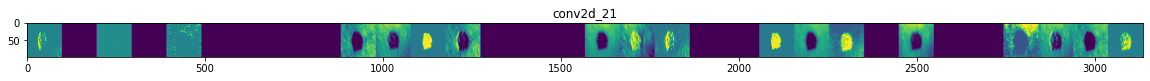

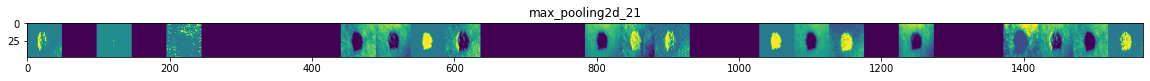

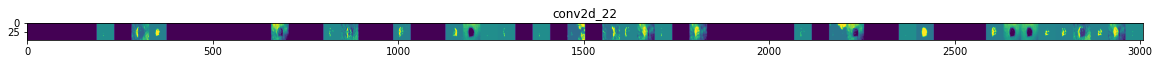

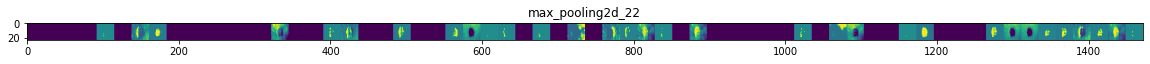

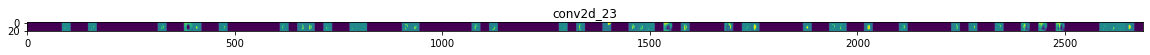

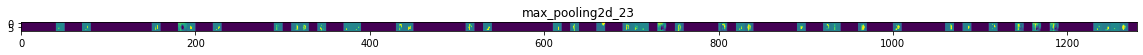

In [69]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# we define a new custom Keras model that receives an input image
# and returns the representations of the layers of the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

# prepare a random image from our dataset
benign_filenames = [os.path.join(train_benign_dir, f) for f in os.listdir(train_benign_dir)]
malig_filenames = [os.path.join(train_malig_dir, f) for f in os.listdir(train_malig_dir)]
img_path = random.choice(benign_filenames + malig_filenames)
img = load_img(img_path, target_size=(image_dim, image_dim))  # this is a raw image in PIL format
x   = img_to_array(img)                           # np array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # np array with shape  (1, 150, 150, 3)

# rescale pixel values 1/255
x /= 255.0

# by making calling the predict method we obtain
# the intermediate representations of this image from the previous model
successive_feature_maps = visualization_model.predict(x)

# let's map the layers of this model with their name
layer_names = [layer.name for layer in model.layers]

# plot everything
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4: # if it is a conv or pooling layer
    n_features = feature_map.shape[-1]  # n features
    size       = feature_map.shape[ 1]  # shape
    
    # create a grid to display the data
    display_grid = np.zeros((size, size * n_features))
    
    # some post-processing
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x

    # show the chart
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Loss in training and validation')

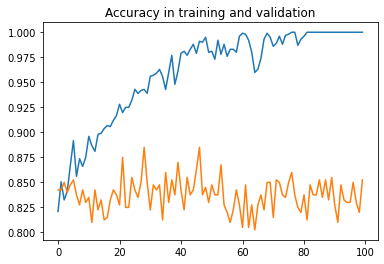

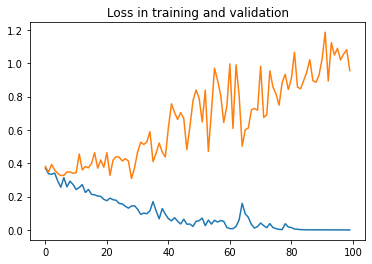

In [59]:
print(history.history.keys())
# get the metrics from history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) 

# plot accuracy with matplotlib
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy in training and validation')
plt.figure()

# plot loss with matplotlib
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss in training and validation')

In [60]:
import numpy as np
from keras.preprocessing import image
import random
import os

# Filepath must end in '/' and contain benign and malignant directories
# Returns a list of n tuples, [(filename, correct_label)...]
# Possible tweak: change filepath instead of returning error?
def random_images(filepath, n):  
    if filepath[-1] != '/':
        print("ERROR: Filepath does not end in '/'.")
        return
    benign_n = random.randint(0, n)
    malig_n = n - benign_n
    benign_dir, malig_dir = os.listdir(filepath + "benign/"), os.listdir(filepath + "malignant/")
    benign_files, malig_files = random.sample(benign_dir, benign_n), random.sample(malig_dir, malig_n)
    output = [("benign/" + filename, "benign") for filename in benign_files]
    output += [("malignant/" + filename, "malignant") for filename in malig_files]
    random.shuffle(output)
    return output
    

In [65]:
import numpy as np
from keras.preprocessing import image
import os

filepath = "../data/test/"
class_labels = ['benign', 'malignant']
n = 200
total_ct = 0
accurate_ct = 0.0

images = random_images(filepath, n)

for file_tuple in images:
    filename, correct_label = file_tuple[0], file_tuple[1]
    img_path = os.path.join(filepath, filename)
    img = image.load_img(img_path, target_size=(image_dim, image_dim))
    x = image.img_to_array(img) / 255 
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=10, verbose=0)
    prediction = ""
    if classes[0] < 0.5:
        prediction = "benign"
    else:
        prediction = "malignant"

    if prediction == correct_label:
        accurate_ct += 1

    print("Image " + str(total_ct) + ": Predicted " + prediction + ", is actually " + correct_label)
    total_ct += 1

print("Rate of accuracy:", accurate_ct / n)


Image 0: Predicted benign, is actually benign
Image 1: Predicted malignant, is actually malignant
Image 2: Predicted malignant, is actually malignant
Image 3: Predicted benign, is actually benign
Image 4: Predicted malignant, is actually malignant
Image 5: Predicted malignant, is actually malignant
Image 6: Predicted benign, is actually malignant
Image 7: Predicted malignant, is actually malignant
Image 8: Predicted malignant, is actually malignant
Image 9: Predicted malignant, is actually malignant
Image 10: Predicted malignant, is actually malignant
Image 11: Predicted malignant, is actually malignant
Image 12: Predicted malignant, is actually malignant
Image 13: Predicted malignant, is actually malignant
Image 14: Predicted malignant, is actually malignant
Image 15: Predicted malignant, is actually malignant
Image 16: Predicted malignant, is actually malignant
Image 17: Predicted malignant, is actually malignant
Image 18: Predicted malignant, is actually malignant
Image 19: Predicte